# Carregamento dos dados

In [5]:
import pandas as pd
data = pd.read_csv('apps_reviews_validacao.xlsx - apps_reviews.csv', sep=',')
data.describe()

,reviewId,app_name,content,sentiment_polarity,sentiment,Unnamed: 5
count,3011,3011,3011,3011,3011,1
unique,3011,10,3011,3,7,1
top,01e23c15-44bf-46b7-b280-40e880d9d49b,Shopee,O app da Shopee é razoável. Apesar de ser fáci...,negative,disgust,X
freq,1,303,1,1742,952,1


In [6]:
data.loc[0,'content']

'O app da Shopee é razoável. Apesar de ser fácil de utilizar, apresenta alguns bugs. Por exemplo: Sugestão de palavra errada no campo de pesquisa que acarreta na busca errada. Sugestões de produtos que não têm nada a ver com coisas de nosso interesse. Dificuldade de acesso de alguns jogos ou travamento durante alguma jogada. Falhas para carregar certos anexos para avaliação dos produtos. No geral, são problemas que se pode contornar, pois não ocorrem com tanta frequência.'

# Pré-processamento

In [7]:
import regex # trabalhar com expressões regulares
data['content'] = data['content'].apply(lambda x: regex.sub(r'[^\p{Latin}]', u' ', str(x)))
data.loc[0,'content']

'O app da Shopee é razoável  Apesar de ser fácil de utilizar  apresenta alguns bugs  Por exemplo  Sugestão de palavra errada no campo de pesquisa que acarreta na busca errada  Sugestões de produtos que não têm nada a ver com coisas de nosso interesse  Dificuldade de acesso de alguns jogos ou travamento durante alguma jogada  Falhas para carregar certos anexos para avaliação dos produtos  No geral  são problemas que se pode contornar  pois não ocorrem com tanta frequência '

# Colocando textos minusculo

In [8]:
data['content'] = data['content'].apply(lambda x: str(x).lower())
data.loc[0,'content']

'o app da shopee é razoável  apesar de ser fácil de utilizar  apresenta alguns bugs  por exemplo  sugestão de palavra errada no campo de pesquisa que acarreta na busca errada  sugestões de produtos que não têm nada a ver com coisas de nosso interesse  dificuldade de acesso de alguns jogos ou travamento durante alguma jogada  falhas para carregar certos anexos para avaliação dos produtos  no geral  são problemas que se pode contornar  pois não ocorrem com tanta frequência '

# Removendo stopwords

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixar os recursos necessários
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(texto):
    # Obter a lista de stopwords em português
    stops_list = stopwords.words("portuguese")
    # Tokenizar o texto
    word_tokens = word_tokenize(texto)
    # Remover as stopwords
    texto_sem_stops = [w for w in word_tokens if w.lower() not in stops_list]
    return " ".join(texto_sem_stops)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arthurwsl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/arthurwsl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
data['content'] = data['content'].apply(remove_stopwords)
data.loc[0,'content']

'app shopee razoável apesar fácil utilizar apresenta alguns bugs exemplo sugestão palavra errada campo pesquisa acarreta busca errada sugestões produtos têm nada ver coisas interesse dificuldade acesso alguns jogos travamento durante alguma jogada falhas carregar certos anexos avaliação produtos geral problemas pode contornar pois ocorrem tanta frequência'

# BERTIMBAU

In [10]:
model.save_pretrained('./bertimbau_emocao')
tokenizer.save_pretrained('./bertimbau_emocao')

('./bertimbau_emocao/tokenizer_config.json',
 './bertimbau_emocao/special_tokens_map.json',
 './bertimbau_emocao/vocab.txt',
 './bertimbau_emocao/added_tokens.json')

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader


# Preparar os dados de entrada e saída
X = data['content'].astype(str).tolist()
y = data['sentiment'].tolist()

# Codificar as etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Carregar o tokenizador e o modelo treinado
tokenizer = BertTokenizer.from_pretrained('./bertimbau_emocao')
model = BertForSequenceClassification.from_pretrained('./bertimbau_emocao')

# Definir o dataset
class ReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

val_dataset = ReviewsDataset(X_val, y_val, tokenizer)

# Obter previsões
def get_predictions(dataset):
    predictions = []
    true_labels = []
    model.eval()
    for batch in DataLoader(dataset, batch_size=8):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

# Função para prever a emoção de um texto
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred = torch.argmax(probs, dim=1)
    return label_encoder.inverse_transform(pred.cpu().numpy())[0]

# Obter previsões e etiquetas verdadeiras
y_pred, y_true = get_predictions(val_dataset)


# Classification report e Matriz de Confusão

/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arthurwsl/classificao_textos/Classificacao_textos/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.69      0.72       153
     disgust       0.68      0.66      0.67       188
        fear       0.00      0.00      0.00         5
   happiness       0.86      0.75      0.80        64
     neutral       0.67      0.42      0.52        19
     sadness       0.70      0.85      0.77       172
    surprise       0.00      0.00      0.00         2

    accuracy                           0.72       603
   macro avg       0.52      0.48      0.50       603
weighted avg       0.71      0.72      0.71       603



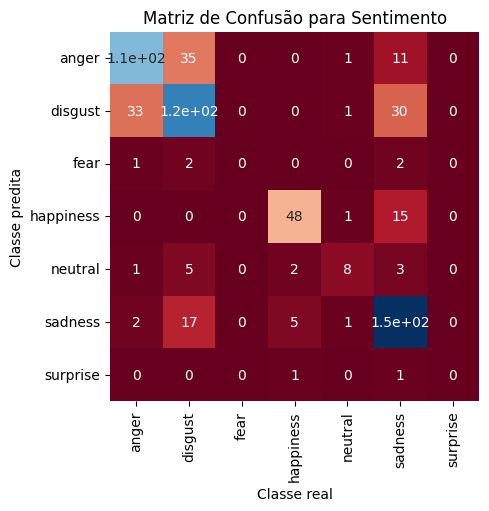

In [24]:

report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)
# Obter categorias únicas de y_val
categorias = np.unique(y_val)

# Ordenar as categorias
labels = sorted(categorias)

# Calcular a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Exibir a matriz de confusão usando seaborn
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False, 
            xticklabels=label_encoder.inverse_transform(labels),
            yticklabels=label_encoder.inverse_transform(labels))

plt.xlabel("Classe real")
plt.ylabel("Classe predita")
plt.title("Matriz de Confusão para Sentimento")
plt.show()

# Teste

In [19]:
import pandas as pd

# Lista de avaliações e emoções retiradas do Google Play refêrentes oo app da shopee
dataTeste ={
    'review': ['Compro a bastante tempo, nunca tive problemas, o que mudou nestes últimos dois meses, a encomenda sai, mas não chega, a data de entrega é alterada automaticamente no aplicativo e a plataforma não resolve a citação, não faz o reembolso e nisso, estou a quase dois meses sem receber a encomenda e sem reembolso, a empresa não soluciona nada! E assim se repete com novas compras!',
    'As lojas são boas, tem bons vendedores. Mas a Shopee é péssima. Tem um atendimento ao cliente péssimo, não sabem o que estão fazendo. Logística terrível e nunca entregam no prazo. E não sabem dar uma resposta coerente. Pode falar com 10 atendentes diferentes e todos vão falar uma versão diferente. O mínimo é uma estrela, mas se tivesse a opção zero, essa seria a minha com toda a certeza. Acho que as palavras incompetência e descaso resumem o serviço prestado.',
    'Eu até que ainda compro no App,mas,depois que comprei um produto,onde o vendedor garantiu ser original,porém não era original e o produto estragou em 1 mês e eu não pude pedir a devolução ou reembolso,fiquei muito desanimado com a Shopee. E,além de tudo, fizeram um programa fidelidade que é a maior enganação, me rebaixaram de nível, mesmo tendo alcançado os pontos necessários pra subir de nível. Esse programa é somente pra recompensar a própria shoppe e nunca os usuários.'],
    'emotion': ['anger','anger','sadness']
    }

df = pd.DataFrame(dataTeste)

print(df.head())


                                              review  emotion
0  Compro a bastante tempo, nunca tive problemas,...    anger
1  As lojas são boas, tem bons vendedores. Mas a ...    anger
2  Eu até que ainda compro no App,mas,depois que ...  sadness


In [20]:
df['review'] = df['review'].apply(lambda x: regex.sub(r'[^\p{Latin}]', u' ', str(x)))
df['review'] = df['review'].apply(lambda x: str(x).lower())
df['review'] = df['review'].apply(remove_stopwords)

df.loc[0,'review']

'compro bastante tempo nunca problemas mudou nestes últimos dois meses encomenda sai chega data entrega alterada automaticamente aplicativo plataforma resolve citação faz reembolso nisso quase dois meses receber encomenda reembolso empresa soluciona nada assim repete novas compras'

In [23]:
emotion = df

emotion['previsao'] = emotion['review'].apply(predict_sentiment)

print('Emoção prevista: ')
print(emotion['previsao'])
print()
print('Emoção real: ')
print(emotion['emotion'])

Emoção prevista: 
0    disgust
1      anger
2      anger
Name: previsao, dtype: object

Emoção real: 
0      anger
1      anger
2    sadness
Name: emotion, dtype: object
